## **Simulating a Distributed Temperature Sensor Network**

## **Overview**
This notebook simulates a distributed temperature sensor network over a gridded dataset. It aims to explore data volume, resource efficiency, and distance-to-hub metrics for multiple sensors placed at random grid locations. The key tasks include:
- **Sensor Simulation:** Random placement of `n` sensors within a temperature grid.
- **Temperature Data Collection:** Extract hourly temperature data for each sensor location.
- **Resource Analysis:** Measure the data volume transferred, compute distances to the central hub, and evaluate resource efficiency in terms of *distance-to-data ratio*.
- **Visualization:** 
  - Plot the temperature grid with sensor and central hub locations.
  - Compare distance-to-hub with resource efficiency.
  - Display the temporal temperature data collected at each sensor location.

## **Key Features**
1. **Temperature Grid Data:**
   - Input data is read from a **NetCDF** file containing hourly temperature grids.
   - Temperature values are converted from Kelvin to Celsius for better interpretation.

2. **Sensor Placement:**
   - Sensors are placed randomly on the grid.
   - Sensor randomness is **reproducible** using a fixed random seed.

3. **Central Hub:**
   - The central hub represents the average grid center.
   - All sensors report temperature data to the hub.

4. **Resource Efficiency Metrics:**
   - **Data Volume:** Number of temperature readings multiplied by data size (4 bytes per reading).
   - **Distance to Hub:** Calculated using the Haversine formula for geographic distance.
   - **Resource Efficiency:** Distance traveled per byte transferred.

5. **Visualization Outputs:**
   - **Grid Plot:** Displays sensor and hub locations over a temperature grid.
   - **Efficiency Plot:** Visualizes the relationship between distance-to-hub and resource efficiency.

---

## **Goals**
This notebook serves as a **proof of concept** for simulating adaptive sensor networks and analyzing the trade-offs between spatial placement, data transmission, and resource usage.

---

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import random
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from math import radians, cos, sin, sqrt, atan2

Sensor Locations: [(np.float64(56.34999999999999), np.float64(-111.95)), (np.float64(57.35), np.float64(-110.95000000000006)), (np.float64(56.949999999999996), np.float64(-111.75000000000001)), (np.float64(57.05), np.float64(-111.85000000000001)), (np.float64(56.249999999999986), np.float64(-111.95))]
Processing Sensor 1: (56.34999999999999, -111.95)
Sensor 1 Report: Data Volume = 384 bytes, Distance to Hub = 51.50 km
Processing Sensor 2: (57.35, -110.95000000000006)
Sensor 2 Report: Data Volume = 384 bytes, Distance to Hub = 77.24 km
Processing Sensor 3: (56.949999999999996, -111.75000000000001)
Sensor 3 Report: Data Volume = 384 bytes, Distance to Hub = 35.02 km
Processing Sensor 4: (57.05, -111.85000000000001)
Sensor 4 Report: Data Volume = 384 bytes, Distance to Hub = 47.56 km
Processing Sensor 5: (56.249999999999986, -111.95)
Sensor 5 Report: Data Volume = 384 bytes, Distance to Hub = 60.37 km

Sensor Network Summary Report:
   Sensor ID  Latitude  Longitude  Total Readings  Data 

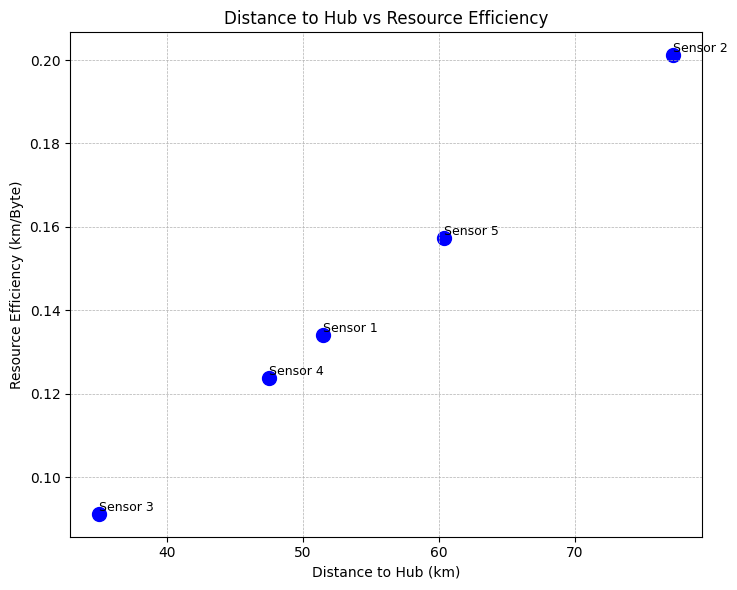

   Sensor ID  Latitude  Longitude  Total Readings  Data Volume (Bytes)  \
0          1     56.35    -111.95              96                  384   
1          2     57.35    -110.95              96                  384   
2          3     56.95    -111.75              96                  384   
3          4     57.05    -111.85              96                  384   
4          5     56.25    -111.95              96                  384   

   Distance to Hub (km)  Resource Efficiency (km/Byte)  
0                 51.50                       0.134121  
1                 77.24                       0.201138  
2                 35.02                       0.091193  
3                 47.56                       0.123864  
4                 60.37                       0.157215  


In [2]:
# Set random seed for reproducibility
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# Load the NetCDF data file
file_path = "../data/combined_era5_fort_mcmurray.nc"  # Adjust path as needed
ds = xr.open_dataset(file_path)

# Convert temperature to Celsius
ds["t2m_celsius"] = ds["t2m"] - 273.15

# Define the central hub location (average grid center)
central_lat, central_lon = ds["latitude"].mean().values, ds["longitude"].mean().values

# Haversine formula to compute distance between two latitude-longitude points
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0  # Radius of Earth in kilometers
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat / 2.0) ** 2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon / 2.0) ** 2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

# Function to simulate n sensors
def simulate_sensors(n_sensors):
    # Randomly select n sensor locations
    latitudes = ds["latitude"].values
    longitudes = ds["longitude"].values
    
    sensor_locations = [(random.choice(latitudes), random.choice(longitudes)) for _ in range(n_sensors)]
    print(f"Sensor Locations: {sensor_locations}")
    
    # Initialize a summary report
    report_list = []

    # Create output folder for storing individual sensor data
    output_folder = "../data/sensor_reports"
    os.makedirs(output_folder, exist_ok=True)

    # Simulate and analyze data for each sensor
    for idx, (sensor_lat, sensor_lon) in enumerate(sensor_locations):
        print(f"Processing Sensor {idx + 1}: ({sensor_lat}, {sensor_lon})")
        
        # Extract temperature data for this sensor
        sensor_data = ds["t2m_celsius"].sel(latitude=sensor_lat, longitude=sensor_lon)
        sensor_df = sensor_data.to_dataframe().reset_index()
        sensor_df = sensor_df[["valid_time", "t2m_celsius"]]
        sensor_df.rename(columns={"t2m_celsius": "temperature_c"}, inplace=True)
        
        # Save the sensor data to a CSV file
        output_file = os.path.join(output_folder, f"sensor_{idx + 1}_data.csv")
        sensor_df.to_csv(output_file, index=False)

        # Calculate data volume and resource efficiency
        num_readings = len(sensor_df)
        bytes_per_reading = 4  # Float32 value (4 bytes per reading)
        data_volume_bytes = num_readings * bytes_per_reading
        
        distance_to_hub = haversine(sensor_lat, sensor_lon, central_lat, central_lon)
        efficiency = distance_to_hub / data_volume_bytes if data_volume_bytes > 0 else 0
        
        # Append to the summary report
        report_list.append({
            "Sensor ID": idx + 1,
            "Latitude": sensor_lat,
            "Longitude": sensor_lon,
            "Total Readings": num_readings,
            "Data Volume (Bytes)": data_volume_bytes,
            "Distance to Hub (km)": round(distance_to_hub, 2),
            "Resource Efficiency (km/Byte)": round(efficiency, 6)
        })

        print(f"Sensor {idx + 1} Report: Data Volume = {data_volume_bytes} bytes, Distance to Hub = {distance_to_hub:.2f} km")
    
    # Convert report to DataFrame and display
    report_df = pd.DataFrame(report_list)
    print("\nSensor Network Summary Report:")
    print(report_df)
    
    # Plot Distance-to-Hub vs Resource Efficiency
    plt.figure(figsize=(7.5, 6))
    plt.scatter(report_df["Distance to Hub (km)"], report_df["Resource Efficiency (km/Byte)"], color='blue', s=100)
    
    for i, txt in enumerate(report_df["Sensor ID"]):
        plt.annotate(f"Sensor {txt}", 
                     (report_df["Distance to Hub (km)"][i], report_df["Resource Efficiency (km/Byte)"][i]),
                     fontsize=9, ha='left', va='bottom')
    
    plt.title("Distance to Hub vs Resource Efficiency")
    plt.xlabel("Distance to Hub (km)")
    plt.ylabel("Resource Efficiency (km/Byte)")
    plt.grid(which="both", linestyle="--", linewidth=0.5)
    plt.tight_layout()
    plt.show()

    return sensor_locations, report_df

# Run the simulation with n sensors
n_sensors = 5  # Define the number of sensors
sensor_locations, report_df = simulate_sensors(n_sensors)

# Display the final report
print(report_df)


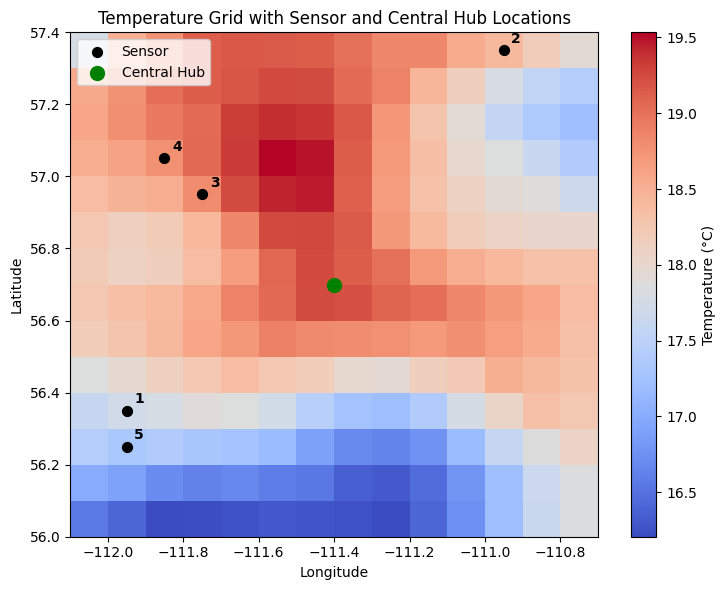

In [3]:
# Plot the first temperature grid with sensor and hub locations
first_grid = ds["t2m_celsius"].isel(valid_time=0)
plt.figure(figsize=(7.5, 6))
plt.pcolormesh(ds["longitude"], ds["latitude"], first_grid, cmap="coolwarm", shading="auto")
plt.colorbar(label="Temperature (°C)")

# Plot all sensor locations and annotate with their numbers
for idx, (lat, lon) in enumerate(sensor_locations):
    plt.scatter(lon, lat, color="black", s=50, label="Sensor" if idx == 0 else "")
    plt.text(lon + 0.02, lat + 0.02, str(idx + 1), fontsize=10, color="black", weight='bold')

# Mark the central hub location
plt.scatter(central_lon, central_lat, color="green", s=100, label="Central Hub")

# Add labels and titles
plt.title("Temperature Grid with Sensor and Central Hub Locations")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.tight_layout()
plt.show()
